:::{canonical-tutorial} tutorials/experimental/dask
:::


# Using `dask` with Scanpy


:::{warning} 🔪 **Beware sharp edges!** 🔪

`dask` support in `scanpy` is new and highly experimental!

Many functions in `scanpy` **do not** support `dask` and may exhibit unexpected behaviour if dask arrays are passed to them. Stick to what's outlined in this tutorial and you should be fine!

Please report any issues you run into over on the issue tracker.
:::


[`dask`](https://www.dask.org) is a popular out-of-core, distributed array processing library that scanpy is beginning to support. Here we walk through a quick tutorial of using `dask` in a simple analysis task.


This notebook relies on optional dependencies in dask, `sklearn-ann` and `annoy`. Install them with:

```sh
pip install -U "anndata[dask]" "scanpy[dask,leiden]" "dask[distributed,diagnostics]" sklearn-ann annoy
```

(`scanpy[dask]` means to install scanpy together with `dask[array]`, but will also always make sure that a compatible dask version is selected)


In [1]:
from pathlib import Path

import dask.distributed as dd
import scanpy as sc
import anndata as ad
import h5py

sc.logging.print_header()

/home/ubuntu/home_drive/volume/scanpy-tutorials/venv/lib/python3.12/site-packages/session_info2/__init__.py:125: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  and (v := getattr(pkg, "__version__", None))
/mnt/volume/tmp/ipykernel_1079366/1992971254.py:8: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  sc.logging.print_header()


Package,Version
dask,2025.1.0
scanpy,1.11.3
anndata,0.12.1
h5py,3.14.0
Component,Info
Python,"3.12.6 (main, Sep 9 2024, 22:11:19) [Clang 18.1.8 ]"
OS,Linux-5.15.0-134-generic-x86_64-with-glibc2.35
CPU,"16 logical CPU cores, x86_64"
GPU,"ID: 0, Tesla T4, Driver: 550.144.03, Memory: 15360 MiB"
Updated,2025-07-29 10:20


Here, we'll be working with a moderately large dataset of 1.4 million cells taken from: [COVID-19 immune features revealed by a large-scale single-cell transcriptome atlas](https://cellxgene.cziscience.com/collections/0a839c4b-10d0-4d64-9272-684c49a2c8ba)


In [2]:
def download(url: str, path: Path) -> None:
    """Download a file from `url` and save it to `path`, showing a progress bar."""
    from tqdm.autonotebook import tqdm
    from urllib.request import urlretrieve

    pb = tqdm(unit="B", unit_scale=True, unit_divisor=1024)

    def update(b: int = 1, bsize: int = 1, tsize: int | None = None):
        if tsize is not None:
            pb.total = tsize
        return pb.update(b * bsize - pb.n)

    try:
        with pb:
            urlretrieve(url, path, reporthook=update)
    except BaseException:
        path.unlink(missing_ok=True)
        raise

In [3]:
cell_atlas_path = Path("data/cell_atlas.h5ad")
cell_atlas_path.parent.mkdir(exist_ok=True)
if not cell_atlas_path.exists():
    download(
        "https://datasets.cellxgene.cziscience.com/82eac9c1-485f-4e21-ab21-8510823d4f6e.h5ad",
        cell_atlas_path,
    )

For more information on using distributed computing via `dask`, please see their [documentation](https://docs.dask.org/en/stable/deploying-python.html). In short, one needs to define both a cluster and a client to have some degree of control over the compute resources dask will use. It's very likely you will have to tune the number of workers and amount of memory per worker along with your chunk sizes.


In [4]:
cluster = dd.LocalCluster(n_workers=3)
client = dd.Client(cluster)

/home/ubuntu/home_drive/volume/scanpy-tutorials/venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44487 instead
  warnings.warn(


2025-07-29 10:49:37,102 - distributed.scheduler - WARNING - Worker failed to heartbeat for 403s; attempting restart: <WorkerState 'tcp://127.0.0.1:40391', name: 2, status: running, memory: 0, processing: 0>
2025-07-29 10:49:49,304 - distributed.scheduler - WARNING - Worker failed to heartbeat for 399s; attempting restart: <WorkerState 'tcp://127.0.0.1:41563', name: 0, status: running, memory: 0, processing: 0>
2025-07-29 10:52:20,725 - distributed.nanny - WARNING - Restarting worker
2025-07-29 10:52:20,727 - distributed.nanny - WARNING - Restarting worker


:::{note}
In this notebook we will be demonstrating some computations in scanpy that use `scipy.sparse` classes within each dask chunk. Be aware that this is currently poorly supported by `dask`, and that if you want to interact with the `dask` arrays in any way other than though the `anndata` and `scanpy` libraries you will likely need to densify each chunk.

All operations in `scanpy` and `anndata` that work with sparse chunks also work with dense chunks.

The advantage of using sparse chunks are:

- The ability to work with fewer, larger chunks
- Accelerated computations per chunk (e.g. don't need to `sum` all those extra zeros)

You can convert from `sparse` to `dense` chunks via:

```python
X = X.map_blocks(lambda x: x.toarray(), dtype=X.dtype, meta=np.array([]))
```

And in reverse:

```python
X = X.map_blocks(sparse.csr_matrix)
```

Note that you will likely have to work with smaller chunks when doing this, via a rechunking operation. We suggest using a factor of the larger chunk size to achieve the most efficient rechunking.

:::


In [5]:
SPARSE_CHUNK_SIZE = 100_000

Dask provides extensive tooling for monitoring your computation. You can access that via the dashboard started when using any of their distributed clusters.


In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44487/status,
Dashboard: http://127.0.0.1:44487/status,Workers: 3
Total threads: 18,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36335,Workers: 3
Dashboard: http://127.0.0.1:44487/status,Total threads: 18
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:41563,Total threads: 6
Dashboard: http://127.0.0.1:42143/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:39367,


We'll convert the `X` representation to `dask` using `anndata.experimental.read_elem_lazy`.


The file we've retrieved from cellxgene has already been processed. Since this tutorial is demonstrating processing from counts, we're just going to access the counts matrix and annotations.


In [7]:
%%time
with h5py.File(cell_atlas_path, "r") as f:
    adata = ad.AnnData(
        obs=ad.io.read_elem(f["obs"]),
        var=ad.io.read_elem(f["var"]),
    )
    adata.X = ad.experimental.read_elem_lazy(
        f["raw/X"], chunks=(SPARSE_CHUNK_SIZE, adata.shape[1])
    )

CPU times: user 2.35 s, sys: 206 ms, total: 2.56 s
Wall time: 2.52 s


We've optimized a number of scanpy functions to be completely lazy. That means it will look like nothing is computed when you call an operation on a dask array, but only later when you hit compute.

In some cases it's currently unavoidable to skip all computation, and these cases will kick off compute for all the delayed operations immediately.


In [8]:
%%time
adata.layers["counts"] = adata.X.copy()  # Making sure we keep access to the raw counts
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 5.01 ms, sys: 7.75 ms, total: 12.8 ms
Wall time: 12.2 ms


In [9]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 1.71 ms


Highly variable genes needs to add entries into `obs`, which currently does not support lazy column. So computation will occur immediately on call.


In [10]:
%%time
sc.pp.highly_variable_genes(adata)

CPU times: user 1.13 s, sys: 185 ms, total: 1.32 s
Wall time: 42.8 s


Scanpy 1.11+ supports computing PCA on `dask` arrays with sparse chunks.


In [11]:
%%time
sc.pp.pca(adata)

CPU times: user 6.75 s, sys: 225 ms, total: 6.97 s
Wall time: 46.5 s


While most of the PCA computation runs immediately, the last step (computing the observation loadings) is lazy, so must be triggered manually to avoid recomputation.


In [12]:
%%time
adata.obsm["X_pca"] = adata.obsm["X_pca"].compute()

CPU times: user 1.96 s, sys: 409 ms, total: 2.37 s
Wall time: 38.6 s


In [13]:
adata

AnnData object with n_obs × n_vars = 1462702 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', '

Now that we've computed our PCA let's take a look at it:


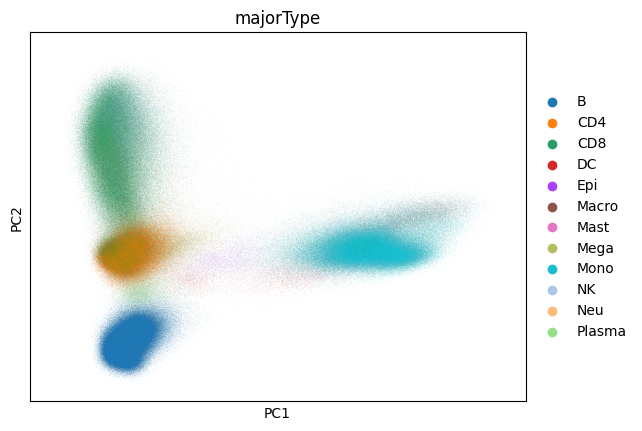

In [14]:
sc.pl.pca(adata, color="majorType")

Further support for `dask` is a work in progress. However, many operations past this point can work with the dimensionality reduction directly in memory. With scanpy `1.10` many of these operations can be accelerated to make working with large datasets significantly easier. For example:

- Using alternative KNN backends for faster neighbor calculation {doc}`/how-to/knn-transformers`
- Using the `igraph` backend for clustering


In [15]:
%%time
from sklearn_ann.kneighbors.annoy import AnnoyTransformer  # noqa: E402

transformer = AnnoyTransformer(n_neighbors=15)
sc.pp.neighbors(adata, transformer=transformer)

/home/ubuntu/home_drive/volume/scanpy-tutorials/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 1min 59s, sys: 3.16 s, total: 2min 2s
Wall time: 1min 39s


In [16]:
%%time
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

CPU times: user 2min 24s, sys: 4.64 s, total: 2min 28s
Wall time: 2min 27s


UMAP computation can still be rather slow, taking longer than the rest of this notebook combined:


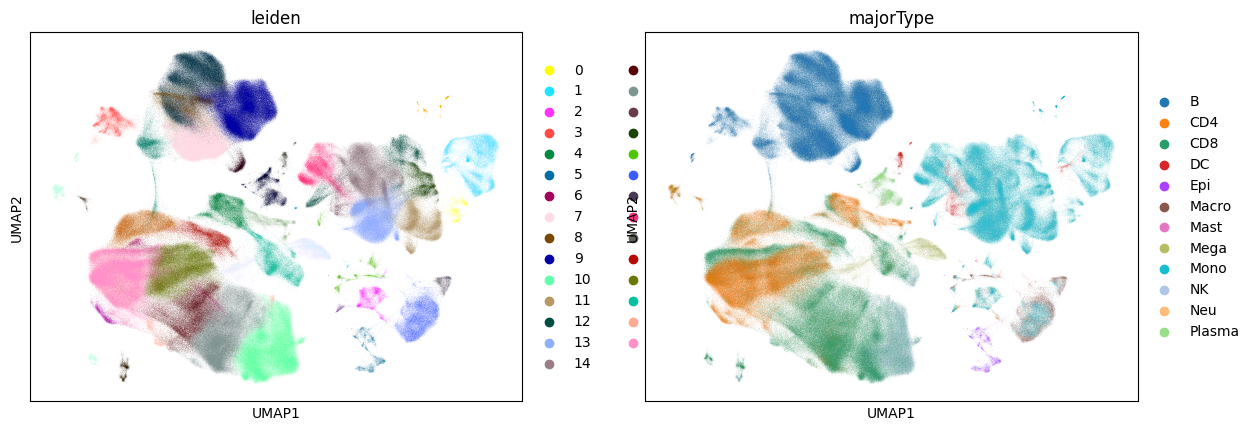

CPU times: user 2h 33min 9s, sys: 24.6 s, total: 2h 33min 33s
Wall time: 26min 2s


In [17]:
%%time
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "majorType"])